# Exploratory Analysis of Amazon-Google Entity Product Matching Data Set

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
# Navigate to current EDA directory as the relative path point
%pwd

'c:\\Users\\seans\\Documents\\neural_entity_matching\\eda'

In [2]:
amz_train = pd.read_csv("../data/amazon_google/Amazon_train.csv",index_col="id")
g_train = pd.read_csv("../data/amazon_google/Google_train.csv",index_col="id")

matches_train = pd.read_csv("../data/amazon_google/AG_perfect_matching_train.csv",index_col = ["idAmazon","idGoogleBase"])
matches_test = pd.read_csv("../data/amazon_google/AG_perfect_matching_test.csv",index_col = ["idAmazon","idGoogleBase"])

In [3]:
amz_train = amz_train.rename(columns = {'title':'title_amzn', "description":"description_amzn","manufacturer":"manufacturer_amzn"} )
g_train = g_train.rename(columns = {'name':'title_g', "description":"description_g","manufacturer":"manufacturer_g"})

Get a distribution of Levenstein edit distance. Idea is that we want to produce data sets with the following characteristics.

* Contains positive matches in the same proportion as the real world data sets.
* Contains examples of positive matches, "difficult" true negatives and easy to spot out easy negatives

In producing this data set we take random samples using a cheap operation on a subset of columns CHOSEN BY THE USER. Sample from positive matches and generate a distribution of edit distances. We can interpet te top 10% of distances as difficuly true positives and the closest 10% as the easy examples then work from there. This is an automatic proceedure which can be made reproducible via the use of a seed


In [4]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [5]:
# Generate a perfect match table
## Join Amazon Products
perfect_matches = pd.merge(amz_train, matches_train, how = 'inner', left_index=  True , right_on = matches_train.index.get_level_values("idAmazon"), suffixes = ("amzn_x","amzn_y"))
perfect_matches = perfect_matches.iloc[:,2:5]
#perfect_matches.columns = perfect_matches.columns.map(lambda x: x + "_amzn")
## Join Google Products
perfect_matches = pd.merge(g_train, perfect_matches, how = 'inner', left_index=  True , right_on = perfect_matches.index.get_level_values("idGoogleBase"), suffixes = ("g_x","g_y"))
perfect_matches = perfect_matches.rename(columns = {'name':'title_g', "description":"description_g","manufacturer":"manufacturer_g"})
## Remove junk columns
perfect_matches.drop(columns = ['key_0', 'Unnamed: 0'],inplace = True)


In [6]:
# Generate Negative Match table
## These rows are not involved in a match AT ALL. Need to reconstruct convincing negative pairs via edit distance
negative_amzn = amz_train[~amz_train.index.isin(perfect_matches.index.get_level_values("idAmazon"))]
negative_g = g_train[~g_train.index.isin(perfect_matches.index.get_level_values("idGoogleBase"))]


In [7]:
SAMPLE_SIZE = 100
true_matches_sample = perfect_matches.sample(n = SAMPLE_SIZE)
negative_amzn_sample = negative_amzn.sample(n = SAMPLE_SIZE)
negative_g_sample = negative_g.sample(n = SAMPLE_SIZE)
negative_matches = pd.concat([negative_amzn_sample.reset_index(), negative_g_sample.reset_index()], axis = 1)
negative_matches_sample = negative_matches.sample(n = SAMPLE_SIZE)



def calculate_edit_distance(x,cols):
    return fuzz.ratio(str(x[cols[0]]), str(x[cols[1]]))

def generate_distance_samples(n, true_matches, negative_matches, distance_cols, plot = True):
    '''
    Inputs:
        n: Sample Size of true and positive match pairs to take WITHOUT replacement
        true_matches/negative_matches: DataFrame of true/negative match pairs
        distance_cols: column names in true/negative match tables used to calculate edit distance.

    Outputs:
        Tuple (true_matches similarities, negative_matches similarities) 
    '''

    true_matches_sample = true_matches.sample(n = n)
    negative_matches_sample = negative_matches.sample(n = n)
    true_matches_sample["similarity"]= true_matches_sample.apply(axis = 1, func = calculate_edit_distance, cols = distance_cols)
    negative_matches_sample["similarity"]= negative_matches_sample.apply(axis = 1, func = calculate_edit_distance, cols = distance_cols)

    if plot:
        sns.distplot(true_matches_sample.similarity)
        sns.distplot(negative_matches_sample.similarity, color = "red")

    return (true_matches_sample.similarity, negative_matches_sample.similarity)









# true_matches_sample["similarity"]= true_matches_sample.apply(axis = 1, func = calculate_edit_distance, cols = ["title_g","title_amzn"])
# negative_matches_sample["similarity"]= negative_matches_sample.apply(axis = 1, func = calculate_edit_distance, cols = ["title_g","title_amzn"])
# sns.distplot(true_matches_sample.similarity)
# sns.distplot(negative_matches_sample.similarity, color = "red")



(idAmazon    idGoogleBase                                                  
 b000fvqo0o  http://www.google.com/base/feeds/snippets/4025192676992669735      57
 b000egidpy  http://www.google.com/base/feeds/snippets/5558998293398547766      92
 b000bdiqpc  http://www.google.com/base/feeds/snippets/17153123894129090968     49
 b000lu89uc  http://www.google.com/base/feeds/snippets/13380169193455086942     55
 b000p9cr34  http://www.google.com/base/feeds/snippets/18421148872586071492     29
 b000bi7uqs  http://www.google.com/base/feeds/snippets/18403148885652932189     21
 b000coxs30  http://www.google.com/base/feeds/snippets/18397190495511936667     57
 b00004ochi  http://www.google.com/base/feeds/snippets/2954833753751672874      61
 b000nkpf7u  http://www.google.com/base/feeds/snippets/18308374908816476565     70
 b000fzxisg  http://www.google.com/base/feeds/snippets/10282477376383378142     93
 b000brgbpa  http://www.google.com/base/feeds/snippets/18413484739795948632     64
 b0007prnjo

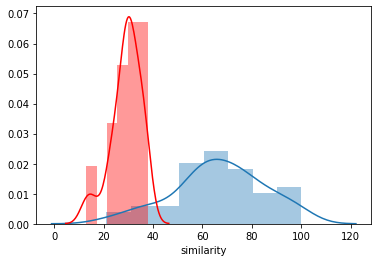

In [8]:
generate_distance_samples(50, perfect_matches ,negative_matches, ["title_g","title_amzn"])



(idAmazon    idGoogleBase                                                  
 b00006sijr  http://www.google.com/base/feeds/snippets/6247936198343071793     35
 b000e5n0mg  http://www.google.com/base/feeds/snippets/10008484121273338467    19
 b000lwfbem  http://www.google.com/base/feeds/snippets/18426249152153175425    20
 b0007lw230  http://www.google.com/base/feeds/snippets/10628460274071713512    25
 b000emcays  http://www.google.com/base/feeds/snippets/727817609597268757      37
 b000m6wlyk  http://www.google.com/base/feeds/snippets/4108712449976038856     35
 b000kmehha  http://www.google.com/base/feeds/snippets/11463298814554093369    11
 b000056b62  http://www.google.com/base/feeds/snippets/18446496383812786183    32
 b000gb0m7y  http://www.google.com/base/feeds/snippets/15318442980556593434     9
 b000hcqqmc  http://www.google.com/base/feeds/snippets/17192874868577413898    43
 b00029rapc  http://www.google.com/base/feeds/snippets/17059526546034030562    48
 b0007sxgla  http://ww

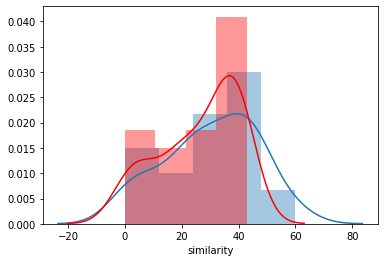

In [9]:
generate_distance_samples(50, perfect_matches ,negative_matches, ["description_g","description_amzn"])


(idAmazon    idGoogleBase                                                  
 b000gaoo7y  http://www.google.com/base/feeds/snippets/18384280629938052082     26
 b00004ochi  http://www.google.com/base/feeds/snippets/9122006997888271580      97
 b000a3x6te  http://www.google.com/base/feeds/snippets/16407653863068941558     17
 b000cpmtwk  http://www.google.com/base/feeds/snippets/1417708435719198149       0
 b000bdiqpc  http://www.google.com/base/feeds/snippets/17153123894129090968      8
 b00006h38u  http://www.google.com/base/feeds/snippets/18406000514365649458     57
 b0009dwkwo  http://www.google.com/base/feeds/snippets/15744420000863688597     53
 b000ej9w0q  http://www.google.com/base/feeds/snippets/10299611596430222322     25
 b0009yegpc  http://www.google.com/base/feeds/snippets/13834985344480832776     33
 b000ro7h3w  http://www.google.com/base/feeds/snippets/2783290587760886650      31
 b0000ycfcw  http://www.google.com/base/feeds/snippets/321181551780335576       26
 b0009zhg8k

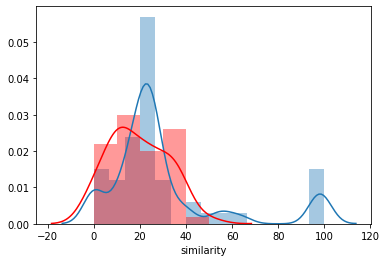

In [10]:
generate_distance_samples(50, perfect_matches ,negative_matches, ["manufacturer_g","manufacturer_amzn"])

In matching products, do the PRICES match exactly?

Now that a similarity function is written. User specifies how the rough specification is calculated. Define a train-validation split function in order to create a sensible sampling of the data using the sampling distancing function